<h1 style="text-align: center;">Feature Engineering & Orthogonalization</h1>

# 1. Setup & Loading Data

Here, we transform raw and processed data into meaningful features for modeling. This includes standardization, stationarity checks, creation of derived features, and orthogonalization to eliminate multicollinearity between predictors while preserving relevance to targets. These engineered features will maximize the predictive power of our models.

In [3]:
import os
from pathlib import Path

repo_root = Path.cwd()

while not (repo_root / ".git").exists() and repo_root.parent != repo_root:
    repo_root = repo_root.parent

os.chdir(repo_root)
print(f"Current working directory set to: {repo_root}")

Current working directory set to: c:\Users\Lenovo\Desktop\Git Uploads\cross-currency-extrema-forecasting


In [4]:
from src.features import FeatureCalculator
from src.features import FeatureSelector
from src.data.split_data import DatasetSplitter
from utils.helpers import check_stationarity, stationarize_by_currency
import pandas as pd

df = pd.read_parquet("data/processed/labeled_data.parquet")

# 2. Feature Engineering & Downsampling

In this section, we compute features that capture price dynamics, volatility regimes, market microstructure, and temporal information. These features are designed to provide the model with economically sound inputs for forecasting future price extrema. Let $O_t$, $H_t$, $L_t$, and $C_t$ be the open, high, low, close prices at time $t$:

| **Feature** | **Formula / Definition** | **Economic Intuition for the Model** |
|--------------|--------------------------|------------------------------------------------------------------------|
| **Log Return** | $ r_t = \ln\left(\frac{C_t}{C_{t-1}}\right) $ | Captures local direction of price changes to helps the model learn short-term drift and trend strength. |
| **Intraday Cumulative Return** | $ \sum_{i=1}^{t} r_i $ (within same day) | Encodes the overall intraday performance to help model detect trend persistence or exhaustion patterns within a session. |
| **Realized Volatility** | $ \sigma_t=\sqrt{\sum_{i=1}^{n} r_i^2} $ | Informs the model about possible range of potential future price changes. |
| **Volatility Adjusted Return** | $ \frac{r_t}{\sigma_t} $ | Aids model in identifying abnormal returns versus noisy fluctuations in patterns. |
| **ATR** | $ ATR_t = MA(\max(H_t-L_t,\quad abs(H_t-C_{t-1}),\quad abs(L_t-C_{t-1}))) $ | Captures intraday range expansion to signal potential price swings or breakouts. |
| **High-Low Spread** | $ H_t - L_t $ | Helps model contextualize how wide future extremes might be. |
| **Close-Open Return** | $ \frac{C_t - O_t}{O_t} $ | Helps model learn patterns of whether markets tend to persist or reverse. |
| **Relative Volume** | $ \frac{V_t}{\frac{1}{n}\sum_{i=t-n}^{t}V_i} $ | Assists model in differentiating between real liquidity-backed price movements vs noise. |
| **RSI** | $ RSI_t = 100 - \frac{100}{1 + \frac{\text{avg gain}}{\text{avg loss}}} $ | Detects overbought/oversold conditions which helps the model in identifying potential reversal zones. |
| **MACD Histogram** | $ MACD_t = EMA_{12}(C_t) - EMA_{26}(C_t)\\ MACD~hist_t = MACD_t - EMA_9(MACD_t) $ | Teaches model to anticipate directional shifts. |
| **sin(minute), cos(minute)** | $ \sin\left(\frac{2\pi t}{1440}\right),\quad \cos\left(\frac{2\pi t}{1440}\right) $ | Encodes cyclical time-of-day info to help model associate time-price change relationships. |
| **SMA** | $ SMA_t = \frac{1}{n}\sum_{i=t-n}^{t} C_i $ | Helps model anchor short-term price action around its mean trend. |


In [5]:
fc = FeatureCalculator(df)
df_features = fc.compute_all_features()

🕒 Starting feature computations...
📊 Computing return figures...
📊 Computing volatility metrics...
📊 Computing microstructure features...
📊 Computing technical indicators...
📊 Computing time features...
📊 Aligning & downsampling to 15mins intervals...
✅ Downsampled dataset from 2,678,400 rows to 178,560 rows using 15-minute intervals.
✅ All features computed.



# 3. Checking for Stationarity

To ensure our time series features exhibit stable statistical properties over time for our XGBoost Regression model (more on it later), we perform a stationarity check using the **Augmented Dickey–Fuller test** across all numeric columns per currency.


In [6]:
stationary_mask = check_stationarity(df_features, 0.1)
stationary_mask

Running ADF test for AUDJPY...
Running ADF test for AUDSGD...
Running ADF test for AUDUSD...
Running ADF test for EURAUD...
Running ADF test for EURGBP...
Running ADF test for EURJPY...
Running ADF test for EURUSD...
Running ADF test for GBPJPY...
Running ADF test for GBPUSD...
Running ADF test for NZDUSD...
Running ADF test for SGDJPY...
Running ADF test for USDCAD...
Running ADF test for USDCHF...
Running ADF test for USDJPY...
Running ADF test for USDZAR...


,open,currency,high,low,close,volume,y_high,y_low,log_ret,cum_ret,...,hl_spread,co_ret,rel_vol,rsi,macd_hist,sma_60,sin_minute,cos_minute,sin_hour,cos_hour
0,False,AUDJPY,False,False,False,True,False,False,True,True,...,True,True,True,True,True,False,True,True,True,True
1,True,AUDSGD,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,AUDUSD,True,False,False,True,True,False,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,EURAUD,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,False,EURGBP,False,False,False,True,False,False,True,True,...,True,True,True,True,True,False,True,True,True,True
5,False,EURJPY,False,False,False,True,False,False,True,True,...,True,True,True,True,True,False,True,True,True,True
6,True,EURUSD,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
7,False,GBPJPY,False,False,False,True,False,False,True,True,...,True,True,True,True,True,False,True,True,True,True
8,True,GBPUSD,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
9,True,NZDUSD,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [17]:
non_stationary = [
    col
    for col in stationary_mask.columns
    if col not in ["currency", "open", "high", "low", "close"]
    and not stationary_mask[col].all()
    and col in df_features.columns
]
non_stationary

['y_high', 'y_low', 'sma_60']


We find in general both regression targets $Y_{high}$ and $Y_{low}$ as well as feature $SMA_{60}$ seem to have unit roots for at least two subdatasets or more.

To handle these, we apply **first-order differencing within each currency group** to remove stochastic trends and stabilize the mean. For a non-stationary feature $ X_t $, the differenced version is computed as:

$$
\Delta X_t = X_t - X_{t-1}
$$


In [8]:
df_features = stationarize_by_currency(df_features, non_stationary)


This transformation is applied chronologically within each currency subset to get new targets $\Delta Y_{high}$, $\Delta Y_{low}$ and new SMA feature $\Delta {SMA}_{60}$ (respectively in our dataset `D_y_high`, `D_y_low`, `D_sma_60`). This means that instead of learning regression targets directly our regression model will learn and infer their first difference and an extra layer will perform cumulative sum with initial value conditions to reconstruct the primary regression target, since we have:

$$
Y_{high,~T} = \sum_{t_0}^T\Delta Y_{high,~i} + Y_{high,~t_0 - 1}\\
Y_{low,~T} = \sum_{t_0}^T\Delta Y_{low,~i} + Y_{low,~t_0 - 1}
$$


# 4. Orthogonalizing Features for Maximum Relevance & Minimum Redundance

In this section, we applied Partial Least Squares Regression as a multivariate feature orthogonalization technique. 

Conceptually, PLSR performs a feature transformation that maximizes feature relevance while minimizing redundancy. It combines ***PCA*** and ***multivariate regression*** to identify latent features by projecting the original feature matrix onto directions that maximize the covariance with the target. 

In our case, since we have two regression targets that are close in values and in nature, we compute the midpoint between them and use it as the reference target $\Delta Y_{mid}=\frac{\Delta Y_{high}+\Delta Y_{low}}{2}$ for the PLSR projection. This ensures that the resulting orthogonalized features remain unbiased with respect to either target, capturing the most informative variance for both simultaneously while reducing multicollinearity.

The impact can be seen in the correlation heatmaps pre- and post-PLSR: New `pls_...` features seem to have little to no multicollinearity compared to original features (after stationarization).

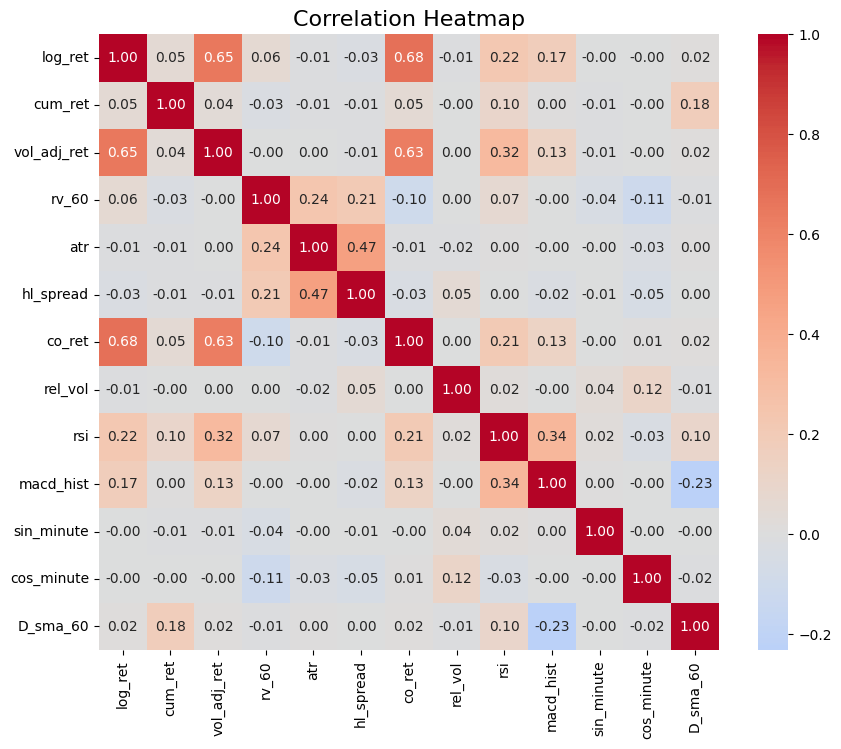

In [9]:
from utils.viz import plot_corr_heatmap


feature_cols = [
    "log_ret",
    "cum_ret",
    "vol_adj_ret",
    "rv_60",
    "atr",
    "hl_spread",
    "co_ret",
    "rel_vol",
    "rsi",
    "macd_hist",
    "sin_minute",
    "cos_minute",
    "D_sma_60",
]

targets = [
    "D_y_high",
    "D_y_low",
]

plot_corr_heatmap(df_features[feature_cols])

In [ ]:
orth_dfs = []
pls = {}
for curr in df_features["currency"].unique():
    df_curr = df_features[df_features["currency"] == curr]
    print(f"---------{curr}---------")
    feature_selector = FeatureSelector(
        df_curr,
        feature_cols=feature_cols,
        targets=targets,
    )

    orth_dfs.append(feature_selector.orthogonalize_features())


df_orthogonal = pd.concat(orth_dfs, ignore_index=False).reset_index()

---------AUDJPY---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------AUDSGD---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------AUDUSD---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------EURAUD---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------EURGBP---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------EURJPY---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------EURUSD---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------GBPJPY---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------GBPUSD---------

In [11]:
orth_features = [col for col in df_orthogonal.columns if col.startswith("pls")]

The following heatmap shows correlation between new latent featuers.

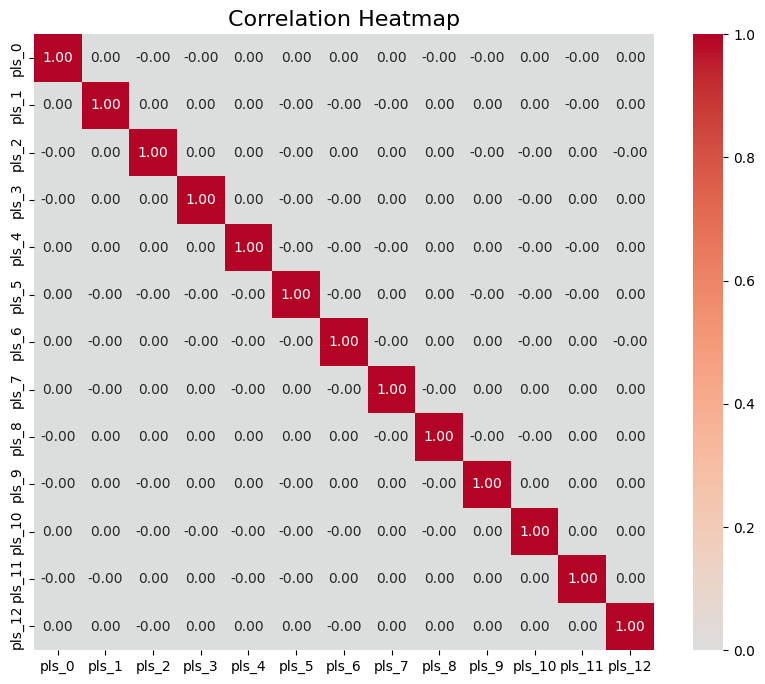

In [12]:
plot_corr_heatmap(df_orthogonal[orth_features])

# 5. Splitting & Saving Datasets

Once feature engineering is done, we perform a dataset split per currency into training, validation, and test sets. The split respects chronological order andt two small embargo windows (~1% each) were applied between train and val and val and test to mitigate cross-contamination and data leakage across sets. Specifically, approximately 70% of the data is used for training, 14% for validation, and 14% for testing (2% cut down in embargos).

In [13]:
df_final = df_orthogonal[
    [
        "open_time",
        "currency",
        "D_y_high",
        "D_y_low",
        "y_high",
        "y_low",
        "high",
        "low",
    ]
    + orth_features
]

In [14]:
df_final.to_parquet("data/processed/final_features.parquet", index=True)

In [15]:
data_splitter = DatasetSplitter()
train, val, test = data_splitter.split(df_final)

🔹 Splitting dataset by currency with embargo...
✅ Split dataset: 124,980 train | 26,775 val | 23,235 test (embargo ~1.00% per currency)


In [16]:
train.to_parquet("data/split/train.parquet", index=True)
val.to_parquet("data/split/val.parquet", index=True)
test.to_parquet("data/split/test.parquet", index=True)

With a robust set of features ready, we are prepared to train, evaluate, and benchmark our models. The next notebook will cover both deep learning and machine learning approaches, comparing performance on the constructed features and targets. See [→ Notebook 04 – Modeling & Benchmarking](04_modeling_and_benchmarking.ipynb)``.